In [1]:
# Instalando e atualizando as bibliotecas necessárias
!pip install pyDOE
!pip install -U seaborn

Requirement already up-to-date: seaborn in c:\programdata\anaconda3\lib\site-packages (0.11.2)


In [2]:
from RASD_TOOLBOX import *

In [3]:
from FINITO_FEM_TOOLBOX import *
import numpy as np
import pandas as pd
from datetime import datetime

In [4]:
def MODULO_ELASTICIDADE_CONCRETO(AGREGADO, F_CK, F_CKJ):
    """
    Esta função calcula os módulos de elasticidade do concreto.  

    Entrada:
    AGREGADO    | Tipo de agragado usado no traço do cimento       |        | string    
                |   'BAS' - Agregado de Basalto                    |        | 
                |   'GRA' - Agregado de Granito                    |        |              
                |   'CAL' - Agregado de Calcário                   |        |
                |   'ARE' - Agregado de Arenito                    |        | 
    F_CK        | Resistência característica à compressão          | kN/m²  | float   
    F_CKJ       | Resistência característica à compressão idade J  | kN/m²  | float
    
    Saída:
    E_CIJ       | Módulo de elasticidade tangente                  | kN/m²  | float
    E_CSJ       | Módulo de elasticidade do secante                | kN/m²  | float   
    """
    # Determinação do módulo tangente E_CI idade T
    if AGREGADO == 'BAS':         
        ALFA_E = 1.2
    elif AGREGADO == 'GRA':         
        ALFA_E = 1.0
    elif AGREGADO == 'CAL':       
        ALFA_E = 0.9
    elif AGREGADO == 'ARE':       
        ALFA_E = 0.7
    F_CK /= 1E3
    if F_CK <= 50:        
        E_CI = ALFA_E * 5600 * np.sqrt(F_CK)
    elif F_CK > 50:   
        E_CI = 21.5 * (10 ** 3) * ALFA_E * (F_CK / 10 + 1.25) ** (1 / 3)
    ALFA_I = 0.8 + 0.2 * F_CK / 80
    if ALFA_I > 1:        
        ALFA_I = 1
    # Determinação do módulo secante E_CS idade T
    E_CS = E_CI * ALFA_I
    if F_CK <= 45 :
        F_CK *= 1E3
        E_CIJ = E_CI * (F_CKJ / F_CK) ** 0.5  
    elif  F_CK > 45 : 
        F_CK *= 1E3
        E_CIJ = E_CI * (F_CKJ / F_CK) ** 0.3  
    E_CSJ = E_CIJ * ALFA_I
    E_CIJ *= 1E3 
    E_CSJ *= 1E3 
    return E_CIJ, E_CSJ

def MOMENTO_RESISTENE_MRD(B_W, D, A_S, F_YK, F_CK, GAMMA_M_ACO, GAMMA_M_CONCRETO):
    """
    Esta função determina o momento resistente M_RD de uma viga de concreto armado.

    Entrada:
    B_W                | Largura da viga                               | m     | float  
    D                  | Altura útil da seção                          | m     | float
    A_S                | Área de aço necessária na seção               | m²    | float
    F_YK               | Tensão de escoamento do aço                   | kN/m² | float
    GAMMA_M_ACO        | Coeficiente parcial de segurança do aço       |       | float
    GAMMA_M_CONCRETO   | Coeficiente parcial de segurança do concreto  |       | float

    Saída:
    M_RD               | Momento resistente da peça                    | kN.m  | Float 
    """
    # Definição dos parâmetros que dependem do F_CK
    F_CK /= 1E3
    if F_CK >  50:
        LAMBDA = 0.80 - ((F_CK - 50) / 400)
        ALPHA_C = (1.00 - ((F_CK - 50) / 200)) * 0.85
    else:
        LAMBDA = 0.80
        ALPHA_C = 0.85
    F_CK *= 1E3    
    F_CD = F_CK / GAMMA_M_CONCRETO
    F_YD = F_YK / GAMMA_M_ACO
    # Linha neutra real e momento resistente
    X_III = (A_S * F_YD) / (ALPHA_C * F_CD * B_W * LAMBDA)
    M_RD = A_S * F_YD * (D - 0.50 * LAMBDA * X_III)
    return M_RD

def CORTANTE_RESISTENE_VRD2(F_CK, B_W, D, GAMMA_M_CONCRETO):
    """
    Esta função verifica o valor da resistência da biela comprimida V_RD2.

    Entrada:
    F_CK               | Resistência característica à compressão         | kN/m² | float
    B_W                | Largura da viga                                 | m     | float  
    D                  | Altura útil da seção                            | m     | float
    GAMMA_M_CONCRETO   | Coeficiente parcial de segurança do concreto    |       | float

    Saída:
    V_RD2              | Força resistente da biela comprimida            | kN    | float
    """
    V_RD2 = RESISTENCIA_BIELA_COMPRIMIDA(F_CK, B_W, D, GAMMA_M_CONCRETO)
    return V_RD

def RESISTENCIA_BIELA_COMPRIMIDA(F_CK, B_W, D, GAMMA_M_CONCRETO):
    """
    Esta função verifica o valor da resistência da biela comprimida V_RD2.

    Entrada:
    F_CK               | Resistência característica à compressão         | kN/m² | float
    B_W                | Largura da viga                                 | m     | float  
    D                  | Altura útil da seção                            | m     | float
    GAMMA_M_CONCRETO   | Coeficiente parcial de segurança do concreto    |       | float
    
    Saída:
    V_RD2              | Resitência da biela comprimida                  | kN    | float 
    """
    # Força resistente da biela de compressão
    F_CK /= 1E3 
    ALFA_V2 = (1 - (F_CK / 250))
    F_CK *= 1E3 
    F_CD = F_CK / GAMMA_M_CONCRETO
    V_RD2 = 0.27 * ALFA_V2 * F_CD * B_W * D
    return V_RD2

def FLECHA_LIMITE_DELTA_RD(L):
    """
    Esta função verifica o valor da flecha limite para uma viga.

    Entrada:
    L         | Vão da peça analisada           | m     | float
    
    Saída:
    DELTA_RD  | Flecha resistente               | m     | float 
    """
    # Flecha Limite
    DELTA_RD = (L / 250)
    return DELTA_RD

def VERIFICA_PILAR(TIPO_PILAR, A_C, RHO, E_S, F_CK, GAMMA_M_CONCRETO):
    """
    Esta função verifica o valor da carga normal máxima em um pilar de concreto armado.
    
    Entrada:
    TIPO_PILAR        | Tipo de pilar da estrutura                    |       | string
                      |    "INTERMEDIARIO"                            |       | 
                      |    "EXTREMIDADE"                              |       | 
                      |    "CANTO"                                    |       | 
    A_C               | Área da seção de concreto do pilar            | m²    | float
    RHO               | Taxa mecânica de armadura                     | %     | float
    E_S               | Módulo de elasticidade do aço                 | kN/m² | float
    F_CK              | Resistência característica à compressão       | kN/m² | float
    GAMMA_M_CONCRETO  | Coeficiente parcial de segurança do concreto  |       | float
    
    Saída:
    N_RD              | Compressão resistente do pilar                | m     | float 
    """
    # Definição do coeficiente de conversão de flexo-compressão para compressão
    if TIPO_PILAR == 'CANTO':
        ALPHA = 2.5
    elif TIPO_PILAR == 'EXTREMIDADE':
        ALPHA = 2.2
    elif TIPO_PILAR == 'INTERMEDIARIO':
        ALPHA = 1.8
    # Tensão de escoamento do aço a 0.20% de deformação de compressão
    SGIMA_SE = 0.2 / 100 * E_S
    # Carga máxima resistente
    F_CD = F_CK / GAMMA_M_CONCRETO
    RHO /= 100
    N_RD = (A_C * (0.85 * F_CD + RHO * SGIMA_SE)) / ALPHA
    return N_RD

def MOMENTO_FISSURACAO(GEOMETRIC_FACTOR, F_CK, H, X_I, I_I):
    if GEOMETRIC_FACTOR == 0:
        ALPHA = 1.2
    elif GEOMETRIC_FACTOR == 1:
        ALPHA = 1.3
    elif GEOMETRIC_FACTOR == 2:
        ALPHA = 1.5
    F_CK /= 1E3
    if F_CK <= 50:
          F_CTM = 0.3 * F_CK ** (2/3)
    elif F_CK > 50:
          F_CTM = 2.12 * np.log(1 + 0.11 * F_CK)
    F_CT = F_CTM * 1E3
    Y_T = H - X_I
    M_R = ALPHA * F_CT * (I_I / Y_T)
    return M_R

def GEOMETRIC_PROPERTIES_STATE_I(H, B_F, B_W, H_F, A_SB, ALPHA_MOD, D):
    A_C = (B_F - B_W) * H_F + B_W * H + A_SB * (ALPHA_MOD - 1)
    X_I = ((B_F - B_W) * ((H_F ** 2) / 2) + B_W * ((H ** 2 ) / 2) + A_SB * (ALPHA_MOD - 1) * D) / A_C
    I_I = ((B_F - B_W) * H_F ** 3) / 12 + (B_W * H ** 3) / 12 + (B_F - B_W) * H_F * (X_I - H_F / 2) ** 2 + B_W * H * (X_I - H / 2) ** 2 + A_SB * (ALPHA_MOD - 1) * (X_I - D) ** 2
    return A_C, X_I, I_I

def GEOMETRIC_PROPERTIES_STATE_II(H, B_F, B_W, H_F, A_SB, A_ST, ALPHA_MOD, D, D_L):
    if B_F <= B_W:
        A_1 = B_W / 2
        A_2 = H_F * (B_F - B_W) + (ALPHA_MOD - 1) * A_ST + ALPHA_MOD * A_SB
        A_3 = - D_L * (ALPHA_MOD - 1) * A_ST - D * ALPHA_MOD * A_SB - (H_F ** 2) / 2 * (B_F - B_W)
        X_II = (-A_2 + np.sqrt(A_2 ** 2 - 4 * A_1 * A_3)) / (2 * A_1)
    elif B_F > B_W:
        A_1 = B_F / 2
        A_2 = H_F * (0) + (ALPHA_MOD - 1) * A_ST + ALPHA_MOD * A_SB
        A_3 = -D_L*(ALPHA_MOD - 1) * A_ST - D * ALPHA_MOD * A_SB - (H_F ** 2) / 2 * (0)
        X_II = (- A_2 + (A_2 ** 2 - 4 * A_1 * A_3) ** 0.50) / (2 * A_1)
        if X_II > H_F:
            A_1 = B_W / 2
            A_2 = H_F * (B_F - B_W) + (ALPHA_MOD - 1) * A_ST + ALPHA_MOD * A_SB
            A_3 = - D_L * (ALPHA_MOD - 1) * A_ST - D * ALPHA_MOD * A_SB - (H_F ** 2) / 2 * (B_F - B_W)
            X_II = (- A_2 + np.sqrt(A_2 ** 2 - 4 * A_1 * A_3)) / (2 * A_1)    
    if X_II <= H_F:
        I_II = (B_F * X_II ** 3) / 3 + ALPHA_MOD * A_SB * (X_II - D) ** 2 + (ALPHA_MOD - 1) * A_ST * (X_II - D_L) ** 2
    else:
        I_II = ((B_F - B_W) * H_F ** 3) / 12 + (B_W * X_II **3 ) / 3 + (B_F - B_W) * (X_II - H_F / 2) ** 2 + ALPHA_MOD * A_SB * (X_II - D) ** 2 + (ALPHA_MOD - 1) * A_ST * (X_II - D_L) ** 2
    return X_II, I_II

def BRANSON_INERTIA(M_R, M_D,I_I, I_II):
    M_RMD = (M_R / M_D) ** 3
    I_BRANSON = M_RMD * I_I + (1 - M_RMD) * I_II
    return I_BRANSON

In [5]:
# https://www.tqs.com.br/v16/destaques/modelo-vi-projeto-estrutural.html
def ANALISE_MATRICIAL_ELU(DADOS):
    F_I = DADOS['CARGA_NODAL']
    F_II = 2 * DADOS['CARGA_NODAL']
    E_CV = DADOS['E_C'] * 0.40
    E_CP = DADOS['E_C'] * 0.80
    A_V = DADOS['A_V']
    A_P = DADOS['A_P']
    I_V = DADOS['I_V']
    I_P = DADOS['I_P']  
    FRAME_00 = {"TYPE_ELEMENT": 0,
                "TYPE_SOLUTION": 0,
                "N_NODES": 37,
                "N_MATERIALS": 2,
                "N_SECTIONS": 2,
                "N_ELEMENTS": 40,
                "N_DOFPRESCRIPTIONS": 6,
                "N_DOFLOADED": 35,
                "N_DOFSPRINGS": 0,
                "COORDINATES": 
                np.array([
                [0.00,0.00],
                [4.50,0.00],
                [0.00,3.00],
                [0.75,3.00],
                [1.50,3.00],
                [2.25,3.00],
                [3.00,3.00],
                [3.75,3.00],
                [4.50,3.00],
                [0.00,6.00],
                [0.75,6.00],
                [1.50,6.00],
                [2.25,6.00],
                [3.00,6.00],
                [3.75,6.00],
                [4.50,6.00],
                [0.00,9.00],
                [0.75,9.00],
                [1.50,9.00],
                [2.25,9.00],
                [3.00,9.00],
                [3.75,9.00],
                [4.50,9.00],
                [0.00,12.00],
                [0.75,12.00],
                [1.50,12.00],
                [2.25,12.00],
                [3.00,12.00],
                [3.75,12.00],
                [4.50,12.00],
                [0.00,15.00],
                [0.75,15.00],
                [1.50,15.00],
                [2.25,15.00],
                [3.00,15.00],
                [3.75,15.00],
                [4.50,15.00]]),

                "ELEMENTS": #NODE 1,NODE 2,MATERIAL ID,SECTION ID,HINGE ID NODE 1,HINGE ID NODE 2
                np.array([
                [0,2,1,1,0,0],#0
                [2,3,0,0,0,0],#1
                [3,4,0,0,0,0],#2
                [4,5,0,0,0,0],#3
                [5,6,0,0,0,0],#4
                [6,7,0,0,0,0],#5
                [7,8,0,0,0,0],#6
                [8,1,1,1,0,0],#7
                [2,9,1,1,0,0],#8
                [9,10,0,0,0,0],#9
                [10,11,0,0,0,0],#10
                [11,12,0,0,0,0],#11
                [12,13,0,0,0,0],#12
                [13,14,0,0,0,0],#13
                [14,15,0,0,0,0],#14
                [15,8,1,1,0,0],#15
                [9,16,1,1,0,0],#16
                [16,17,0,0,0,0],#17
                [17,18,0,0,0,0],#18
                [18,19,0,0,0,0],#19
                [19,20,0,0,0,0],#20
                [20,21,0,0,0,0],#21
                [21,22,0,0,0,0],#22
                [22,15,1,1,0,0],#23
                [16,23,1,1,0,0],#24
                [23,24,0,0,0,0],#25
                [24,25,0,0,0,0],#26
                [25,26,0,0,0,0],#27
                [26,27,0,0,0,0],#28
                [27,28,0,0,0,0],#29
                [28,29,0,0,0,0],#30
                [29,22,1,1,0,0],#31
                [23,30,1,1,0,0],#32
                [30,31,0,0,0,0],#33
                [31,32,0,0,0,0],#34
                [32,33,0,0,0,0],#35
                [33,34,0,0,0,0],#36
                [34,35,0,0,0,0],#37
                [35,36,0,0,0,0],#38
                [36,29,1,1,0,0]]),#39

                "MATERIALS": #YOUNG, POISSON,DENSITY, THERMAL COEFFICIENT
                np.array([[E_CV, 1, 1, 1], [E_CP, 1, 1, 1]]),
                
                "SECTIONS": #AREA, INERTIA 1, INERTIA 2, X GC,Y GC
                
                np.array([[A_V , I_V, I_V, 0, 0], [A_P , I_P, I_P, 0, 0]]),
                "PRESCRIBED DISPLACEMENTS": #NODE,DIRECTION(X=0,Y=1,Z=2),VALUE
                np.array([
                [0,0,0],
                [0,1,0],
                [0,2,0],
                [1,0,0],
                [1,1,0],
                [1,2,0]]),
                
                "ELEMENT LOADS": None,
                
                "NODAL LOADS":  #NODE,DIRECTION(X=0,Y=1,Z=2),VALUE
                np.array([
                [2,1,-F_I,0],
                [3,1,-F_II,0],
                [4,1,-F_II,0],
                [5,1,-F_II,0],
                [6,1,-F_II,0],
                [7,1,-F_II,0],
                [8,1,-F_I,0],
                [9,1,-F_I,0],
                [10,1,-F_II,0],
                [11,1,-F_II,0],
                [12,1,-F_II,0],
                [13,1,-F_II,0],
                [14,1,-F_II,0],
                [15,1,-F_I,0],
                [16,1,-F_I,0],
                [17,1,-F_II,0],
                [18,1,-F_II,0],
                [19,1,-F_II,0],
                [20,1,-F_II,0],
                [21,1,-F_II,0],
                [22,1,-F_I,0],
                [23,1,-F_I,0],
                [24,1,-F_II,0],
                [25,1,-F_II,0],
                [26,1,-F_II,0],
                [27,1,-F_II,0],
                [28,1,-F_II,0],
                [29,1,-F_I,0],
                [30,1,-F_I,0],
                [31,1,-F_II,0],
                [32,1,-F_II,0],
                [33,1,-F_II,0],
                [34,1,-F_II,0],
                [35,1,-F_II,0],
                [36,1,-F_I,0]]),
            
                "SPRINGS": None}    

    FRAME_00_RESULTS = MEF1D(DICTIONARY = FRAME_00)
    return FRAME_00_RESULTS

def ANALISE_MATRICIAL_ELS(DADOS):
    F_I = DADOS['CARGA_NODAL']
    F_II = 2 * DADOS['CARGA_NODAL']
    E_CV = DADOS['E_C'] * 1.00
    E_CP = DADOS['E_C'] * 1.00
    A_V = DADOS['A_V']
    A_P = DADOS['A_P']
    I_V = DADOS['I_V']
    I_P = DADOS['I_P']  
    FRAME_00 = {"TYPE_ELEMENT": 0,
                "TYPE_SOLUTION": 0,
                "N_NODES": 37,
                "N_MATERIALS": 2,
                "N_SECTIONS": 2,
                "N_ELEMENTS": 40,
                "N_DOFPRESCRIPTIONS": 6,
                "N_DOFLOADED": 35,
                "N_DOFSPRINGS": 0,
                "COORDINATES": 
                np.array([
                [0.00,0.00],
                [4.50,0.00],
                [0.00,3.00],
                [0.75,3.00],
                [1.50,3.00],
                [2.25,3.00],
                [3.00,3.00],
                [3.75,3.00],
                [4.50,3.00],
                [0.00,6.00],
                [0.75,6.00],
                [1.50,6.00],
                [2.25,6.00],
                [3.00,6.00],
                [3.75,6.00],
                [4.50,6.00],
                [0.00,9.00],
                [0.75,9.00],
                [1.50,9.00],
                [2.25,9.00],
                [3.00,9.00],
                [3.75,9.00],
                [4.50,9.00],
                [0.00,12.00],
                [0.75,12.00],
                [1.50,12.00],
                [2.25,12.00],
                [3.00,12.00],
                [3.75,12.00],
                [4.50,12.00],
                [0.00,15.00],
                [0.75,15.00],
                [1.50,15.00],
                [2.25,15.00],
                [3.00,15.00],
                [3.75,15.00],
                [4.50,15.00]]),

                "ELEMENTS": #NODE 1,NODE 2,MATERIAL ID,SECTION ID,HINGE ID NODE 1,HINGE ID NODE 2
                np.array([
                [0,2,1,1,0,0],#0
                [2,3,0,0,0,0],#1
                [3,4,0,0,0,0],#2
                [4,5,0,0,0,0],#3
                [5,6,0,0,0,0],#4
                [6,7,0,0,0,0],#5
                [7,8,0,0,0,0],#6
                [8,1,1,1,0,0],#7
                [2,9,1,1,0,0],#8
                [9,10,0,0,0,0],#9
                [10,11,0,0,0,0],#10
                [11,12,0,0,0,0],#11
                [12,13,0,0,0,0],#12
                [13,14,0,0,0,0],#13
                [14,15,0,0,0,0],#14
                [15,8,1,1,0,0],#15
                [9,16,1,1,0,0],#16
                [16,17,0,0,0,0],#17
                [17,18,0,0,0,0],#18
                [18,19,0,0,0,0],#19
                [19,20,0,0,0,0],#20
                [20,21,0,0,0,0],#21
                [21,22,0,0,0,0],#22
                [22,15,1,1,0,0],#23
                [16,23,1,1,0,0],#24
                [23,24,0,0,0,0],#25
                [24,25,0,0,0,0],#26
                [25,26,0,0,0,0],#27
                [26,27,0,0,0,0],#28
                [27,28,0,0,0,0],#29
                [28,29,0,0,0,0],#30
                [29,22,1,1,0,0],#31
                [23,30,1,1,0,0],#32
                [30,31,0,0,0,0],#33
                [31,32,0,0,0,0],#34
                [32,33,0,0,0,0],#35
                [33,34,0,0,0,0],#36
                [34,35,0,0,0,0],#37
                [35,36,0,0,0,0],#38
                [36,29,1,1,0,0]]),#39

                "MATERIALS": #YOUNG, POISSON,DENSITY, THERMAL COEFFICIENT
                np.array([[E_CV, 1, 1, 1], [E_CP, 1, 1, 1]]),
                
                "SECTIONS": #AREA, INERTIA 1, INERTIA 2, X GC,Y GC
                
                np.array([[A_V , I_V, I_V, 0, 0], [A_P , I_P, I_P, 0, 0]]),
                "PRESCRIBED DISPLACEMENTS": #NODE,DIRECTION(X=0,Y=1,Z=2),VALUE
                np.array([
                [0,0,0],
                [0,1,0],
                [0,2,0],
                [1,0,0],
                [1,1,0],
                [1,2,0]]),
                
                "ELEMENT LOADS": None,
                
                "NODAL LOADS":  #NODE,DIRECTION(X=0,Y=1,Z=2),VALUE
                np.array([
                [2,1,-F_I,0],
                [3,1,-F_II,0],
                [4,1,-F_II,0],
                [5,1,-F_II,0],
                [6,1,-F_II,0],
                [7,1,-F_II,0],
                [8,1,-F_I,0],
                [9,1,-F_I,0],
                [10,1,-F_II,0],
                [11,1,-F_II,0],
                [12,1,-F_II,0],
                [13,1,-F_II,0],
                [14,1,-F_II,0],
                [15,1,-F_I,0],
                [16,1,-F_I,0],
                [17,1,-F_II,0],
                [18,1,-F_II,0],
                [19,1,-F_II,0],
                [20,1,-F_II,0],
                [21,1,-F_II,0],
                [22,1,-F_I,0],
                [23,1,-F_I,0],
                [24,1,-F_II,0],
                [25,1,-F_II,0],
                [26,1,-F_II,0],
                [27,1,-F_II,0],
                [28,1,-F_II,0],
                [29,1,-F_I,0],
                [30,1,-F_I,0],
                [31,1,-F_II,0],
                [32,1,-F_II,0],
                [33,1,-F_II,0],
                [34,1,-F_II,0],
                [35,1,-F_II,0],
                [36,1,-F_I,0]]),
            
                "SPRINGS": None}    

    FRAME_00_RESULTS = MEF1D(DICTIONARY = FRAME_00)
    return FRAME_00_RESULTS

def ANALISE_MATRICIAL_VIGA_1(DADOS):
    F_I = DADOS['CARGA_NODAL']
    F_II = 2 * DADOS['CARGA_NODAL']
    E_CV = DADOS['E_C'] * 1.00
    E_CP = DADOS['E_C'] * 1.00
    A_V = DADOS['A_V']
    A_P = DADOS['A_P']
    I_V = DADOS['I_V']
    I_P = DADOS['I_P']  
    FRAME_00 = {"TYPE_ELEMENT": 0,
                "TYPE_SOLUTION": 0,
                "N_NODES": 11,
                "N_MATERIALS": 2,
                "N_SECTIONS": 2,
                "N_ELEMENTS": 10,
                "N_DOFPRESCRIPTIONS": 8,
                "N_DOFLOADED": 7,
                "N_DOFSPRINGS": 0,
                "COORDINATES": 
                np.array([
                [0.00,0.00],
                [4.50,0.00],
                [0.00,3.00],
                [0.75,3.00],
                [1.50,3.00],
                [2.25,3.00],
                [3.00,3.00],
                [3.75,3.00],
                [4.50,3.00],
                [0.00,6.00],
                [4.50,6.00]]),

                "ELEMENTS": #NODE 1,NODE 2,MATERIAL ID,SECTION ID,HINGE ID NODE 1,HINGE ID NODE 2
                np.array([
                [0,2,1,1,0,0],#0
                [2,3,0,0,0,0],#1
                [3,4,0,0,0,0],#2
                [4,5,0,0,0,0],#3
                [5,6,0,0,0,0],#4
                [6,7,0,0,0,0],#5
                [7,8,0,0,0,0],#6
                [8,1,1,1,0,0],#7
                [2,9,1,1,0,0],#8
                [8,10,1,1,0,0]]),#9

                "MATERIALS": #YOUNG, POISSON,DENSITY, THERMAL COEFFICIENT
                np.array([[E_CV, 1, 1, 1], [E_CP, 1, 1, 1]]),
                
                "SECTIONS": #AREA, INERTIA 1, INERTIA 2, X GC,Y GC
                
                np.array([[A_V , I_V, I_V, 0, 0], [A_P , I_P, I_P, 0, 0]]),
                
                "PRESCRIBED DISPLACEMENTS": #NODE,DIRECTION(X=0,Y=1,Z=2),VALUE
                np.array([
                [0,0,0],
                [0,1,0],
                [1,0,0],
                [1,1,0],
                [9,0,0],
                [9,1,0],
                [10,0,0],
                [10,1,0]]),
                
                "ELEMENT LOADS": None,
                
                "NODAL LOADS":  #NODE,DIRECTION(X=0,Y=1,Z=2),VALUE
                np.array([
                [2,1,-F_I,0],
                [3,1,-F_II,0],
                [4,1,-F_II,0],
                [5,1,-F_II,0],
                [6,1,-F_II,0],
                [7,1,-F_II,0],
                [8,1,-F_I,0]]),
            
                "SPRINGS": None}    

    FRAME_00_RESULTS = MEF1D(DICTIONARY = FRAME_00)
    return FRAME_00_RESULTS

In [6]:
G_MED = 1.06 * 4.60
Q_MED = 0.64
F_CKMED = 1.17 * 25 * 1E3
F_YKMED = 1.22 * 500 * 1E3
E_YKMED = 1.22 * 200 * 1E6
G = ['NORMAL', G_MED, (0.12 * G_MED)]        
Q = ['GUMBEL MAX', Q_MED, (0.40 * Q_MED)]
F_CK = ['NORMAL', F_CKMED, (F_CKMED * 0.15)]
F_YK = ['NORMAL', F_YKMED, (F_YKMED * 0.04)]
E_SK = ['NORMAL', E_YKMED, (E_YKMED * 0.04)]

#G = ['NORMAL', G_MED, 0]        
#Q = ['GUMBEL MAX', Q_MED, 0]
#F_CK = ['NORMAL', F_CKMED, 0]
#F_YK = ['NORMAL', F_YKMED, 0]
#E_SK = ['NORMAL', E_YKMED, 0]

POP = [100000]

SETUP = {'N_REP': len(POP),
        'POP': POP,
        'N_G': 4,
        'D': 5 ,
        'VARS': [G, Q, F_CK, F_YK, E_SK],
        'MODEL': 'MCS'}

In [7]:
def OBJ(X):
    # Dados fixos do sistema estrutural
    ALTURA_UTIL = 0.255
    LARGURA = 0.14
    GAMMA_C = 1.00
    GAMMA_S = 1.00
    GAMMA_F = 1.00
    PSI = 1.00
    VAO = 4.50   
    A_SV = 1.48 * 1E-4
    A_V = 0.14 * 0.30
    I_V = (0.14 * 0.30 ** 3) / 12
    A_P = 0.14 * 0.40
    I_P = (0.14 * 0.40 ** 3) / 12
    
    # Atribuição das variáveis aleatórias e variáveis de estado
    DEAD = X[0]
    LIVE = X[1]
    F_CK = X[2]
    F_YK = X[3]
    E_SK = X[4]
    E_CI, E_CS = MODULO_ELASTICIDADE_CONCRETO('GRA', F_CK, F_CK)
    ALPHA_MOD = E_SK / E_CS
    M_F = MOMENTO_FISSURACAO(2, F_CK, 0.30, 0.15, I_V)
    X_II, I_II = GEOMETRIC_PROPERTIES_STATE_II(0.30, 0.14, 0.14, 0, A_SV, 0, ALPHA_MOD, ALTURA_UTIL, 0)
    #print('dados',DEAD, LIVE, F_CK, F_YK, E_SK)
    #print('variáveis de estado', M_F, E_CI, E_CS, ALPHA_MOD, X_II, I_II)

    # Análise estrutural carga (G + Q) * GAMMA_F
    DADOS_0 = {'CARGA_NODAL': GAMMA_F * (DEAD + LIVE), 'E_C': E_CS, 'A_V': A_V, 'I_V': I_V, 'A_P': A_P, 'I_P': I_P}
    FRAME_0 = ANALISE_MATRICIAL_ELU(DADOS_0)
    
    # Resultados Viga V01 e P01 do 1º pavimento
    M_SD = max(FRAME_0[3]['M'])
    V_SD = max(FRAME_0[1]['V'])
    N_SD = np.abs(max(FRAME_0[0]['N']))
    
    # Análise estrutural carga G + Q * PSI  
    DADOS_1 = {'CARGA_NODAL': DEAD + LIVE * PSI, 'E_C': E_CI, 'A_V': A_V, 'I_V': I_V, 'A_P': A_P, 'I_P': I_P}
    FRAME_1 = ANALISE_MATRICIAL_ELS(DADOS_1)
    M_SDSER = max(FRAME_1[3]['M'])
    #print('momento serviço', M_SDSER)

    # Inércia e rigidez equivalente da peça
    if M_SDSER > M_F:
        I_M = BRANSON_INERTIA(M_F, M_SDSER, I_V, I_II)
        I_CNOVO = I_M
    else:
        I_CNOVO  = I_V
    #print('inercia', I_V, I_CNOVO, DEAD + LIVE * PSI)
    DADOS_2 = {'CARGA_NODAL': DEAD + LIVE * PSI, 'E_C': E_CI, 'A_V': A_V, 'I_V': I_CNOVO, 'A_P': A_P, 'I_P': I_P}
    FRAME_2 = ANALISE_MATRICIAL_VIGA_1(DADOS_2)
    
    DELTA_S = FRAME_2[3]['UY'][10]
    DELTA_SD = np.abs(DELTA_S) * 2.5
    #print('flecha', DELTA_S, DELTA_SD)
    # Capacidade do sistema ao momento fletor
    M_RD = MOMENTO_RESISTENE_MRD(LARGURA, ALTURA_UTIL, A_SV, F_YK, F_CK, GAMMA_S, GAMMA_C)
    
    # Capacidade do sistema ao esforço cortante
    V_RD2 = RESISTENCIA_BIELA_COMPRIMIDA(F_CK, LARGURA, ALTURA_UTIL, GAMMA_C)
    
    # Capacidade do sistema a deflexão
    DELTA_RD = FLECHA_LIMITE_DELTA_RD(VAO)
    
    # Capacidade do sistema a carga normal
    N_RD = VERIFICA_PILAR('CANTO', A_P, 2, E_SK, F_CK, GAMMA_C)
    
    # Montagem da capacidade e demanda do sistema em listas
    S = [M_SD, V_SD, DELTA_SD, N_SD]
    R = [M_RD, V_RD2, DELTA_RD, N_RD]
    G_0 = - M_RD + M_SD
    G_1 = - V_RD2 + V_SD
    G_2 = - DELTA_RD + DELTA_SD
    #print('flecha analise', DELTA_SD, DELTA_RD, G_2)
    G_3 = - N_RD + N_SD
    G = [G_0, G_1, G_2, G_3]
    return R, S, G

In [8]:
RESULTS_TEST = RASD_STOCHASTIC(SETUP, OBJ)

In [9]:
RESULTS_TEST[len(POP)-1]['TOTAL RESULTS']

,X_0,X_1,X_2,X_3,X_4,R_0,R_1,R_2,R_3,S_0,...,S_2,S_3,G_0,G_1,G_2,G_3,I_0,I_1,I_2,I_3
0,5.114026,0.790565,25726.084106,604360.546734,2.425537e+08,21.501900,222.456153,0.018,707.152744,14.769027,...,0.016087,177.137718,-6.732873,-192.933200,-0.001913,-530.015026,0.0,0.0,0.0,0.0
1,4.701957,0.652654,36683.401167,601014.735055,2.233848e+08,21.776048,301.707577,0.018,898.604745,13.393374,...,0.008336,160.638322,-8.382674,-274.934524,-0.009664,-737.966423,0.0,0.0,0.0,0.0
2,4.540885,1.244463,25387.647616,592199.622013,2.444560e+08,21.078278,219.860934,0.018,702.413349,14.470769,...,0.015592,173.560454,-6.607509,-190.934192,-0.002408,-528.852894,0.0,0.0,0.0,0.0
3,5.969934,1.081132,23028.198700,618410.451414,2.506269e+08,21.810399,201.522640,0.018,663.018642,17.636681,...,0.023383,211.531974,-4.173719,-166.267311,0.005383,-451.486668,0.0,0.0,1.0,0.0
4,4.686470,0.787772,25407.590125,528463.284315,2.550440e+08,18.932595,220.014104,0.018,712.279970,13.692603,...,0.013715,164.227241,-5.239992,-192.642897,-0.004285,-548.052729,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4.376209,0.841245,24506.660602,595630.759901,2.427386e+08,21.146760,213.063877,0.018,684.100593,13.050307,...,0.013095,156.523621,-8.096454,-186.976607,-0.004905,-527.576972,0.0,0.0,0.0,0.0
99996,5.775807,0.594862,24773.810398,624016.297739,2.657842e+08,22.103785,215.131334,0.018,709.836028,15.934817,...,0.018362,191.120046,-6.168968,-183.277993,0.000362,-518.715982,0.0,0.0,1.0,0.0
99997,4.353138,0.391150,27418.114796,611463.252522,2.422960e+08,21.821606,235.298619,0.018,739.138152,11.866787,...,0.009199,142.328644,-9.954819,-211.577178,-0.008801,-596.809508,0.0,0.0,0.0,0.0
99998,4.499892,1.172958,28553.411525,597431.915593,2.422960e+08,21.396637,243.791731,0.018,760.754202,14.189379,...,0.013294,170.185502,-7.207258,-215.427480,-0.004706,-590.568700,0.0,0.0,0.0,0.0


In [10]:
RESULTS_TEST[len(POP)-1]

{'TOTAL RESULTS':             X_0       X_1           X_2            X_3           X_4  \
 0      5.114026  0.790565  25726.084106  604360.546734  2.425537e+08   
 1      4.701957  0.652654  36683.401167  601014.735055  2.233848e+08   
 2      4.540885  1.244463  25387.647616  592199.622013  2.444560e+08   
 3      5.969934  1.081132  23028.198700  618410.451414  2.506269e+08   
 4      4.686470  0.787772  25407.590125  528463.284315  2.550440e+08   
 ...         ...       ...           ...            ...           ...   
 99995  4.376209  0.841245  24506.660602  595630.759901  2.427386e+08   
 99996  5.775807  0.594862  24773.810398  624016.297739  2.657842e+08   
 99997  4.353138  0.391150  27418.114796  611463.252522  2.422960e+08   
 99998  4.499892  1.172958  28553.411525  597431.915593  2.422960e+08   
 99999  5.380000  1.321944  31653.926789  600279.946076  2.468727e+08   
 
              R_0         R_1    R_2         R_3        S_0  ...       S_2  \
 0      21.501900  222.4561

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


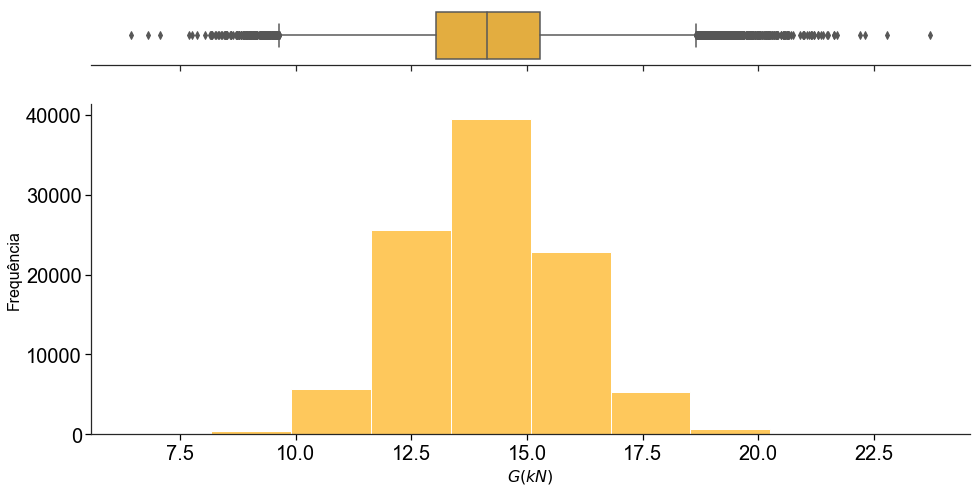

In [11]:
#Representação de histograma de frequência e boxplot da variável
#DADOS = RESULTS_TEST[0]['TOTAL RESULTS']
DADOS = RESULTS_TEST[len(POP)-1]['TOTAL RESULTS']
OPCOES_GRAFICAS = { 'NAME': 'WANDER11',
                    'WIDTH': 0.40, 
                    'HEIGHT': 0.20,
                    'DPI': 600, 
                    'BINS' : 10,
                    'EXTENSION': '.svg',
                    'X AXIS SIZE': 20,
                    'Y AXIS SIZE': 20,
                    'AXISES COLOR': '#000000',
                    'X AXIS LABEL': '$G(kN)$',
                    'LABELS SIZE': 16,
                    'LABELS COLOR': '#000000',  
                    'CHART COLOR': '#FEB625',
                    'KDE': False}
# RESULTS X_0 VARIABLE
OPCOES_DADOS = {'DATASET': DADOS, 'COLUMN': 'S_0'}      
# CALL PLOT
RASD_PLOT_1(OPCOES_DADOS, OPCOES_GRAFICAS)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


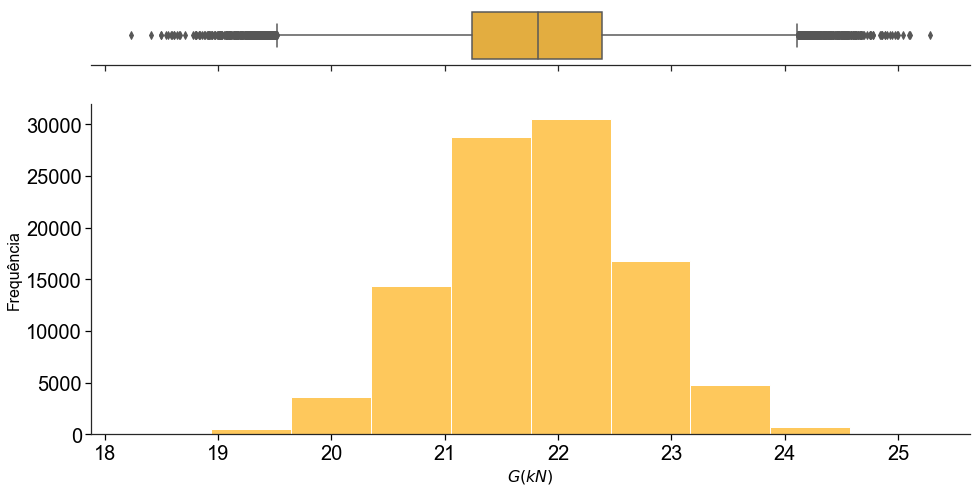

In [12]:
#Representação de histograma de frequência e boxplot da variável
#DADOS = RESULTS_TEST[len(POP)-1]['TOTAL RESULTS']
OPCOES_GRAFICAS = {'NAME': 'WANDER12',
                'WIDTH': 0.40, 
                'HEIGHT': 0.20, 
                'X AXIS SIZE': 20,
                'Y AXIS SIZE': 20,
                'AXISES COLOR': '#000000',
                'X AXIS LABEL': '$G(kN)$',
                'LABELS SIZE': 16,
                'LABELS COLOR': '#000000',  
                'CHART COLOR': '#FEB625',
                'KDE': False,
                'DPI': 600, 
                'BINS' : 10,
                'EXTENSION': '.svg'}
# RESULTS X_0 VARIABLE
OPCOES_DADOS = {'DATASET': DADOS, 'COLUMN': 'R_0'}      
# CALL PLOT
RASD_PLOT_1(OPCOES_DADOS, OPCOES_GRAFICAS)

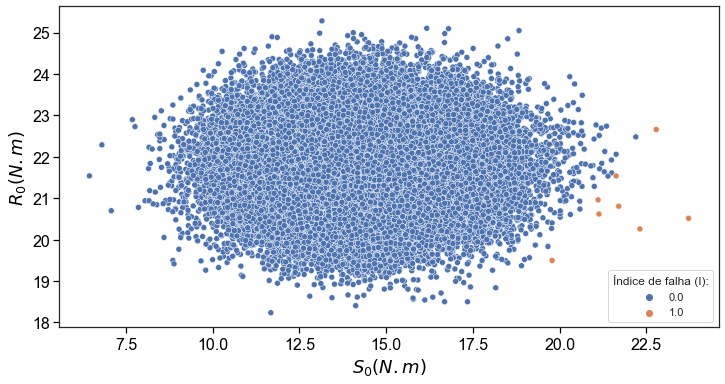

In [13]:
#Representação do gráfico de dispersão dos valores S_0, R_0  e índice de falha I.
OPCOES_GRAFICAS = { 'NAME': 'WANDER2',
                    'EXTENSION': '.svg',
                    'DPI': 600,
                    'WIDTH': 0.300, 
                    'HEIGHT': 0.150,              
                    'X AXIS SIZE': 16,
                    'Y AXIS SIZE': 16,
                    'AXISES COLOR': '#000000',
                    'X AXIS LABEL': '$S_0 (N.m)$',
                    'Y AXIS LABEL': '$R_0 (N.m)$',
                    'LABELS SIZE': 18,
                    'LABELS COLOR': '#000000',
                    'LOC LEGEND': 'lower right',
                    'TITLE LEGEND': 'Índice de falha (I):'}
# RESULTS
OPCOES_DADOS = {'DATASET': DADOS, 'X DATA': 'S_0', 'Y DATA': 'R_0', 'HUE VALUE': 'I_0'}    
# CALL PLOT
RASD_PLOT_2(OPCOES_DADOS, OPCOES_GRAFICAS)

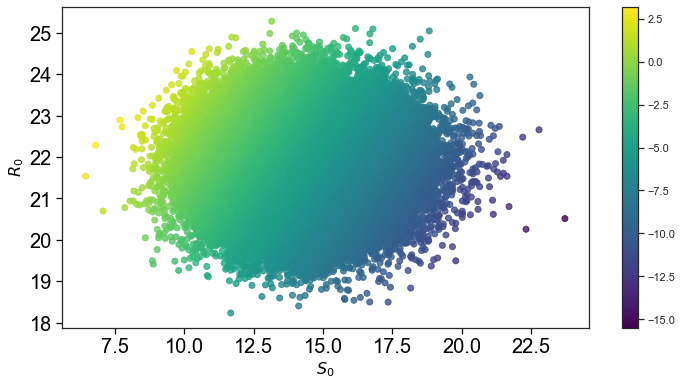

In [14]:
#Representação do gráfico de dispersão dos valores S_0 e R_0 com mapeamento de cores.
OPCOES_GRAFICAS = { 'NAME': 'WANDER3',
                    'EXTENSION': '.svg',
                    'DPI': 600,
                    'WIDTH': 0.30, 
                    'HEIGHT': 0.15,              
                    'X AXIS SIZE': 20,
                    'Y AXIS SIZE': 20,
                    'AXISES COLOR': '#000000',
                    'X AXIS LABEL': '$S_0$',
                    'Y AXIS LABEL': '$R_0$',
                    'LABELS SIZE': 16,
                    'LABELS COLOR': '#000000',
                    'TRANSPARENCY': 0.8,
                    'COLOR MAP': 'viridis'}


# RESULTS
OPCOES_DADOS = {'DATASET': DADOS, 'X DATA': 'S_0', 'Y DATA': 'R_0', 'G VALUE': 'G_0'}       

# CALL PLOT
RASD_PLOT_3(OPCOES_DADOS, OPCOES_GRAFICAS)

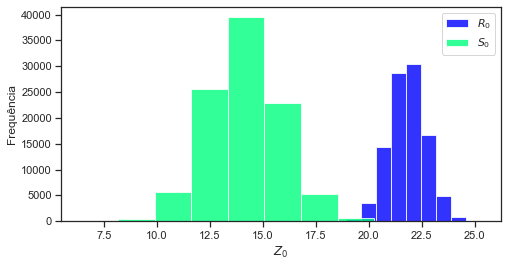

In [15]:
#Representação dos histogramas de frequência de S_0 e R_0 na região de interferência.
OPCOES_GRAFICAS = { 'NAME': 'WANDER4',
                    'EXTENSION': '.svg',
                    'DPI': 600,
                    'WIDTH': 0.20,
                    'HEIGHT': 0.10,
                    'X AXIS SIZE': 20,
                    'Y AXIS SIZE': 20,
                    'AXISES COLOR': '#00000',
                    'HIST 1 LABEL': '$R_0$',
                    'HIST 2 LABEL': '$S_0$',
                    'HIST 1 COLOR': '#0000FF',
                    'HIST 2 COLOR': '#00FF7F',
                    'X AXIS LABEL': '$Z_0$',
                    'Y AXIS LABEL': 'Frequência',
                    'LABELS SIZE': 16,
                    'LABELS COLOR': '#000000',
                    'BINS': 10,
                    'TRANSPARENCY': 0.80}

# RESULTS
OPCOES_DADOS = {'DATASET': DADOS, 'HIST_1': 'R_0', 'HIST_2': 'S_0'}  

# CALL PLOT
RASD_PLOT_4(OPCOES_DADOS, OPCOES_GRAFICAS)

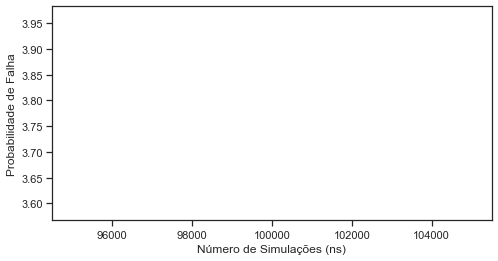

In [16]:
OPCOES_GRAFICAS = {'NAME': 'WANDER51',
                    'EXTENSION': '.svg',
                    'DPI': 600,
                    'WIDTH': 0.20,
                    'HEIGHT': 0.10,
                    'X AXIS SIZE': 20,
                    'Y AXIS SIZE': 20,
                    'AXISES COLOR': '#000000',
                    'X AXIS LABEL': 'Número de Simulações (ns)',
                    'Y AXIS LABEL': 'Probabilidade de Falha',
                    'LABELS SIZE': 16,
                    'LABELS COLOR': '#000000',
                    'CHART COLOR': 'black',
                    'POPULATION' : POP,
                    'TYPE' : 'beta'}

# RESULTS
OPCOES_DADOS = {'DATASET': RESULTS_TEST, 'G NUMBER': 0}       

# CALL PLOT
RASD_PLOT_5(OPCOES_DADOS, OPCOES_GRAFICAS)

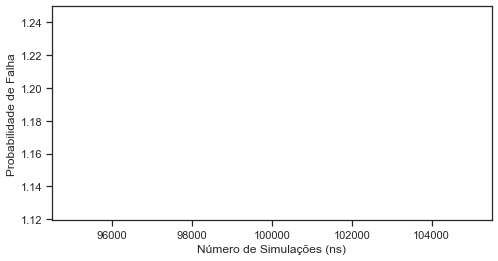

In [17]:
OPCOES_GRAFICAS = {'NAME': 'WANDER52',
                    'EXTENSION': '.svg',
                    'DPI': 600,
                    'WIDTH': 0.20,
                    'HEIGHT': 0.10,
                    'X AXIS SIZE': 20,
                    'Y AXIS SIZE': 20,
                    'AXISES COLOR': '#000000',
                    'X AXIS LABEL': 'Número de Simulações (ns)',
                    'Y AXIS LABEL': 'Probabilidade de Falha',
                    'LABELS SIZE': 16,
                    'LABELS COLOR': '#000000',
                    'CHART COLOR': 'black',
                    'POPULATION' : POP,
                    'TYPE' : 'beta'}

# RESULTS
OPCOES_DADOS = {'DATASET': RESULTS_TEST, 'G NUMBER': 2}       

# CALL PLOT
RASD_PLOT_5(OPCOES_DADOS, OPCOES_GRAFICAS)